In [1]:
import numpy as np
import math
from datetime import datetime
import matplotlib.pyplot as plt

La clase operador contiene la información de los horarios en UTC de cada uno de los operadores así como su disponibilidad y la carga por día y guardia

In [2]:
class Operador:

    CARGA_POR_GUARDIA_EN_DIA_LABORAL = 3
    DIAS_LABORABLES = ["L", "M", "X", "J", "V"]

    CARGA_POR_GUARDIA_EN_FIN_DE_SEMANA = 6
    DIAS_FIN_DE_SEMANA = ["S", "D"]

    DIAS = ["L", "M", "X", "J", "V", "S", "D"]

    NUMERO_HORAS_POR_GUARDIA = 1

    CARGA_POR_HORA_EN_HORARIO_LABORAL = 1
    CARGA_POR_HORA_EN_HORARIO_NO_LABORAL = 1.5
    CARGA_POR_HORA_EN_HORARIO_NOCTURNO = 4

    HORARIO_LABORAL = [7.5, 17.0]
    HORARIO_NO_LABORAL = [17.0, 24.0]
    HORARIO_NOCTURNO = [0.0, 7.5]

    horarios = [HORARIO_LABORAL,
                HORARIO_NO_LABORAL,
                HORARIO_NOCTURNO]

    GUARDIA_OCASO = [18.5, 1.0]
    GUARDIA_MEDIANOCHE = [1.0, 7.5]
    GUARDIA_ALBA = [7.5, 8.5]

    guardias = [GUARDIA_OCASO,
                GUARDIA_MEDIANOCHE,
                GUARDIA_ALBA]


    def __init__(self,
                 nombre,
                 utc=0,
                 disponibilidad_ocaso=None,
                 disponibilidad_medianoche=None,
                 disponibilidad_alba=None,
                 vacaciones=[]):
        """
        Constructor de la clase Operador

        Input:
            nombre (string): Nombre del operador
            utc (int): Zona UTC del operador
            disponibilidad_ocaso (bool): Si es False, no se asignará guardia de ocaso al operador
            disponibilidad_medianoche (bool): Si es False, no se asignará guardia de medianoche al operador
            disponibilidad_alba (bool): Si es False, no se asignará guardia de medianoche al operador
            vacaciones (list): Una lista con los días de vacaciones
        Returns:
            Operador: La instancia del Operador
        """
        self.nombre = nombre
        self.utc = utc
        print("---", nombre, "---")
        print("Horarios en utc local del operador:")
        msg = f"    Horario laboral: {self.parsear_franja(self.HORARIO_LABORAL)}"
        print(msg)
        msg = f"    Horario no laboral: {self.parsear_franja(self.HORARIO_NO_LABORAL)}"
        print(msg)
        msg = f"    Horario nocturno: {self.parsear_franja(self.HORARIO_NOCTURNO)}"
        print(msg)

        # Calculamos carga por guardia
        print(f"Zona: UTC+{self.utc}")
        print("* Guardia Ocaso:")
        self.carga_guardia_ocaso = self.calcular_carga_guardia(self.GUARDIA_OCASO)
        print("* Guardia Medianoche:")
        self.carga_guardia_medianoche = self.calcular_carga_guardia(self.GUARDIA_MEDIANOCHE)
        print("* Guardia Alba:")
        self.carga_guardia_alba = self.calcular_carga_guardia(self.GUARDIA_ALBA)
        print("----------\n")

        # Calculamos disponibilidades
        if disponibilidad_ocaso == None:
            self.disponible_ocaso = self.calcular_disponibilidad(self.GUARDIA_OCASO)
        else:
            self.disponible_ocaso = disponibilidad_ocaso
        if disponibilidad_medianoche == None:
            self.disponible_medianoche = self.calcular_disponibilidad(self.GUARDIA_MEDIANOCHE)
        else:
            self.disponible_medianoche = disponibilidad_medianoche
        if disponibilidad_alba == None:
            self.disponible_alba = self.calcular_disponibilidad(self.GUARDIA_ALBA)
        else:
            self.disponible_alba = disponibilidad_alba

        self.vacaciones = vacaciones


    def calcular_disponibilidad(self,
                                guardia):
        """
        Método que calcula la disponibilidad del operador en una guardia (horario UT) según la hora a la que empieza

        Input:
            guardia (list): Una lista de 2 componentes con la hora de inicio y final de la guardia

        Returns:
            disponible (bool): True si está disponible (la guardia empieza entre 7.5 y las 24), False si no lo está
        """

        # Calculamos el inicio de la guardia
        guardia_utc = self.calcular_franja_horaria_en_utc(guardia)
        inicio_utc_guardia = guardia_utc[0]

        # Si el inicio cae entre horario laboral e inicio de horario nocturno está disponible
        disponible = False
        if  self.HORARIO_LABORAL[0] <= inicio_utc_guardia <= self.HORARIO_NO_LABORAL[1]:
            disponible = True

        return disponible


    def get_disponibilidad(self):
        """
        Devuelve las disponibilidades del operador
        """
        return [self.disponible_ocaso, self.disponible_medianoche, self.disponible_alba]


    def comprobar_disponibilidad(self,
                                 dia,
                                 indice_guardia):
        """
        Comprueba la disponibilidad del operador en un día concreto
        """

        # Miramos si esa guardia es compatible con el operador
        disp = [self.disponible_ocaso, self.disponible_medianoche, self.disponible_alba]
        if not disp[indice_guardia]:
            return False


        # Calculamos el inicio de la guardia en utc
        inicio_ut_guardia = self.guardias[indice_guardia][0]
        inicio_utc_guardia = inicio_ut_guardia + self.utc

        dia_guardia = dia
        if inicio_utc_guardia < 0:
            dia_guardia = dia-1
        elif inicio_utc_guardia >= 24:
            dia_guardia = dia+1

        disponibilidad = True
        if dia_guardia in self.vacaciones:
            disponibilidad = False

        return disponibilidad


    def calcular_carga_guardia(self,
                               guardia):
        """
        Calcula la carga de trabajo en una guardia. La carga se calcula en base al número de horas
        en horario laboral, no laboral y nocturno que trabaja el operador en el turno.

        Input:
            guardia (list): Una lista con la hora de inicio (los minutos se pasan al sistema
                             decimal, por ejemplo, las 8:30 en la tupla es 8.5) y la hora de
                             fin de la guardia

            num_guardia (int): El identificador de la guardia, 0 OCASO, 1 MEDIANOCHE, 2 ALBA

        Returns:
            carga_total (float): La carga total de trabajo durante una guardia
        """

        # En primer lugar pasamos la hora de la guardia al horario utc del operador
        franja_utc_operario = self.calcular_franja_horaria_en_utc(guardia)
        msg = f"    Horario UT de la guardia: {self.parsear_franja(guardia)}"
        print(msg)
        msg = f"    Horario UTC del operador: {self.parsear_franja(franja_utc_operario)}"
        print(msg)
        # Calculamos el número de horas en cada franja
        n_horas = self.calcular_horas(franja_utc_operario)
        n_horas_laborables, n_horas_no_laborables, n_horas_nocturnas = n_horas

        # Calculamos la carga en cada franja
        carga_laboral = self.CARGA_POR_HORA_EN_HORARIO_LABORAL * n_horas_laborables
        carga_no_laboral = self.CARGA_POR_HORA_EN_HORARIO_NO_LABORAL * n_horas_no_laborables
        carga_nocturna = self.CARGA_POR_HORA_EN_HORARIO_NOCTURNO * n_horas_nocturnas

        # Calculamos la carga total
        carga_total = carga_laboral + \
                      carga_no_laboral + \
                      carga_nocturna

        # Mensajes para debuggear
        horas_text = ["horas laborables",
                      "horas no laborables",
                      "horas nocturnas"]

        # Bucle
        inicio = franja_utc_operario[0]
        indice = 0

        # Ajustamos el índice para empezar a contar desde la guardia que corresponde en la franja del operador
        while inicio < self.horarios[indice][0]:
            indice += 1

        # Bucle para contar las horas trabajadas en total
        for i in range(3):
            h = n_horas[indice]
            if h > 0:
                franja = [inicio, inicio+h]
                msg = f"    {h} {horas_text[indice]} trabajadas: {self.parsear_franja(franja)}"
                print(msg)

            inicio = (inicio+h)%24
            indice = (indice+1)%3

        msg = f"    Carga de la guardia: {carga_total}"
        print(msg)

        return carga_total


    def parsear_hora(self,
                     hora):
        """
        Crea un string dada una hora en sistema decimal

        Input:
            hora (float): La hora a parsear (En sistema decimal, 8.5 significa 8:30)

        Returns:
            hora_parseada (string): La hora parseada en formato HH:MM
        """

        segundos = hora * 3600
        hora_parseada = datetime.utcfromtimestamp(segundos).strftime("%H:%M")
        return hora_parseada


    def plot_guardias_en_ax(self,
                            ax):
        """
        Hace un subplot de la carga por guardia del operador

        Input
            ax (matplotlib.axes): El subplot en el que se introducirán los datos

        Returns:
            ax (matplotlib.axes): El subplot en el que se introducirán los datos
        """

        franja_utc_ocaso = self.calcular_franja_horaria_en_utc(self.GUARDIA_OCASO)
        n_horas_ocaso = self.calcular_horas(franja_utc_ocaso)

        franja_utc_medianoche = self.calcular_franja_horaria_en_utc(self.GUARDIA_MEDIANOCHE)
        n_horas_medianoche = self.calcular_horas(franja_utc_medianoche)

        franja_utc_alba = self.calcular_franja_horaria_en_utc(self.GUARDIA_ALBA)
        n_horas_alba = self.calcular_horas(franja_utc_alba)

        category_names = ['Horas laborables', 'Horas no laborables', 'Horas nocturnas']
        results = {f"Guardia Ocaso\n {self.parsear_franja(franja_utc_ocaso)}": n_horas_ocaso,
                   f"Guardia Medianoche\n {self.parsear_franja(franja_utc_medianoche)}": n_horas_medianoche,
                   f"Guardia Alba\n {self.parsear_franja(franja_utc_alba)}": n_horas_alba}
        labels = list(results.keys())
        data = np.array(list(results.values()))
        data_cum = data.cumsum(axis=1)
        color=['green', 'orange', 'red']
        ax.invert_yaxis()
        ax.set_xlim(0, 10)
        ax.set_xlabel('Horas en guardia')
        ax.title.set_text(f"{self.nombre} (UTC {self.utc:+})")

        for i, (colname, color) in enumerate(zip(category_names, color)):
            widths = data[:, i]
            starts = data_cum[:, i] - widths
            rects = ax.barh(labels, widths, left=starts, height=0.5, label=colname, color=color)
            #ax.bar_label(rects, label_type='center')

        for c in ax.containers:
            # Filter the labels
            labels = [v if v > 0 else "" for v in c.datavalues]
            ax.bar_label(c, labels=labels, label_type="center")

        text = f"Carga Guardia Ocaso: \n" + \
               f"{n_horas_ocaso[0]}x{self.CARGA_POR_HORA_EN_HORARIO_LABORAL} + " + \
               f"{n_horas_ocaso[1]}x{self.CARGA_POR_HORA_EN_HORARIO_NO_LABORAL} + " + \
               f"{n_horas_ocaso[2]}x{self.CARGA_POR_HORA_EN_HORARIO_NOCTURNO}" + \
               f" = {self.get_carga_guardia_ocaso()}\n"
        ax.text(10.5, 0.5, text)

        text = f"Carga Guardia Medianoche: \n" + \
               f"{n_horas_medianoche[0]}x{self.CARGA_POR_HORA_EN_HORARIO_LABORAL} + " + \
               f"{n_horas_medianoche[1]}x{self.CARGA_POR_HORA_EN_HORARIO_NO_LABORAL} + " + \
               f"{n_horas_medianoche[2]}x{self.CARGA_POR_HORA_EN_HORARIO_NOCTURNO}" + \
               f" = {self.get_carga_guardia_medianoche()}\n"
        ax.text(10.5, 1.5, text)

        text = f"Carga Guardia Alba: \n" + \
               f"{n_horas_alba[0]}x{self.CARGA_POR_HORA_EN_HORARIO_LABORAL} + " + \
               f"{n_horas_alba[1]}x{self.CARGA_POR_HORA_EN_HORARIO_NO_LABORAL} + " + \
               f"{n_horas_alba[2]}x{self.CARGA_POR_HORA_EN_HORARIO_NOCTURNO}" + \
               f" = {self.get_carga_guardia_alba()}\n"

        ax.text(10.5, 2.5, text)


        ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize='small')
        return ax


    def calcular_franja_horaria_en_utc(self,
                                       guardia):
        """
        Hace el cambio de hora ut a hora utc del operario

        Input:
            guardia (list): Una lista con la hora de inicio (los minutos se pasan al sistema
                            decimal, por ejemplo, las 8:30 en la tupla es 8.5) y la hora de
                            fin de la guardia en horario UT

        Returns:
            guardia_utc (list): Una lista con la hora de inicio (los minutos se pasan al sistema
                                decimal, por ejemplo, las 8:30 en la tupla es 8.5) y la hora de
                                fin de la guardia en horario UTC
        """

        guardia_utc = [(guardia[0]+self.utc)%24, (guardia[1]+self.utc)%24]
        return guardia_utc


    def parsear_franja(self,
                       franja):
        """
        Crea un string en formato H:M

        Input:
            franja (list): Una lista con la hora de inicio y la hora de fin de una
                           franja horaria

        Returns:
            franja_parseada (string): La franja horaria parseada
        """

        franja_parseada = f"{self.parsear_hora(franja[0])} - {self.parsear_hora(franja[1])}"
        return franja_parseada


    def calcular_carga_en_dia(self,
                              indice_dia,
                              indice_guardia,
                              verbose=False):
        """
        Calcula la carga total de la guardia, teniendo en cuenta las horas y el día que cubre

        Input:
            indice_dia (int): El índice del día (horario UT) en el array self.DIAS (Lunes=0, ...)
            indice_guardia (int): El índice de la guardia en el array de guardis (ocaso=0, ...)
            verbose (bool): Si es True, se muestran mensajes para debuggear
        """
        # Calculamos el inicio de la guardia en utc
        inicio_ut_guardia = self.guardias[indice_guardia][0]
        inicio_utc_guardia = inicio_ut_guardia + self.utc
        indice_dia_utc = indice_dia

        if inicio_utc_guardia < 0:
            indice_dia_utc = (indice_dia - 1)%7
        elif inicio_utc_guardia > 24:
            indice_dia_utc = (indice_dia + 1)%7

        dia = self.DIAS[indice_dia_utc]
        carga_dia = self.CARGA_POR_GUARDIA_EN_DIA_LABORAL if dia in self.DIAS_LABORABLES else self.CARGA_POR_GUARDIA_EN_FIN_DE_SEMANA

        # Si es viernes por la tarde cuenta como fin de semana
        if dia == "V" and inicio_utc_guardia >= 17.0:
          carga_dia = self.CARGA_POR_GUARDIA_EN_FIN_DE_SEMANA

        # Si es domingo por la tarde cuenta como dia laborable
        if dia == "D" and inicio_utc_guardia >= 17.0:
          carga_dia = self.CARGA_POR_GUARDIA_EN_FIN_DE_SEMANA

        # Calculamos la carga de la guardia según el tipo
        if indice_guardia == 0:
            carga_guardia = self.get_carga_guardia_ocaso()
        elif indice_guardia == 1:
            carga_guardia = self.get_carga_guardia_medianoche()
        else:
            carga_guardia = self.get_carga_guardia_alba()

        carga_total = carga_dia + carga_guardia
        if verbose:
            print(f"   La guardia para {self.nombre} empieza el {dia} a las {self.parsear_hora(inicio_utc_guardia)} con carga de {carga_total}")

        return carga_total


    def get_carga_guardia_ocaso(self):
        """
        Devuelve la carga de la guardia de ocaso (sin tener en cuenta el día que ocurre)
        """
        return self.carga_guardia_ocaso


    def get_carga_guardia_medianoche(self):
        """
        Devuelve la carga de la guardia de medianoche (sin tener en cuenta el día que ocurre)
        """
        return self.carga_guardia_medianoche


    def get_carga_guardia_alba(self):
        """
        Devuelve la carga de la guardia del alba (sin tener en cuenta el día que ocurre)
        """
        return self.carga_guardia_alba


    def calcular_horas(self,
                       horario_operador):
        """
        Calcula el número de horas que son comunes entre dos franjas horarias

        Input:
            horario_operador (tuple): Tupla con hora de inicio y hora final de la franja de
                                      trabajo del operador

        Returns:
            n_horas (list): El número de horas comunes a cada franja de trabajo
        """

        # Leemos el inicio y el fin de la guardia en el horario utc del operario
        inicio_operador = horario_operador[0]
        fin_operador = horario_operador[0] + self.NUMERO_HORAS_POR_GUARDIA
        if fin_operador > 24:
            fin_operador = fin_operador % 24

        if fin_operador > horario_operador[1]:
            fin_operador = horario_operador[1]

        # Si hay cambio de día durante la guardia laseparamos en dos,
        # Una hasta las 00:00 y otra desde las 00:00
        if inicio_operador > fin_operador:
            # Dividimos la guardia
            primera_guardia = [inicio_operador, 24.0]
            segunda_guardia = [0.0, fin_operador]

            # Calculamos las horas de la primera parte
            p_nhl, p_nhnl, p_nhn = self.calcular_horas(primera_guardia)

            if p_nhl + p_nhnl + p_nhn >= self.NUMERO_HORAS_POR_GUARDIA:
                return [p_nhl, p_nhnl, p_nhn]
            # Calculamos las horas de la segunda parte
            s_nhl, s_nhnl, s_nhn = self.calcular_horas(segunda_guardia)

            # Calculamos el total de horas (maximo 2 horas en total de trabajo)
            n_horas_laborables = p_nhl + s_nhl
            n_horas_no_laborables = p_nhnl + s_nhnl
            n_horas_nocturnas = p_nhn + s_nhn

            return [n_horas_laborables, n_horas_no_laborables, n_horas_nocturnas]


        # Si no hay cambio de día, iteramos sobre los horarios comprobando horas comunes
        total_horas = 0
        n_horas = [0, 0, 0]
        for i in range(len(self.horarios)+1):
            indice_horario = i%len(self.horarios)
            horario = self.horarios[indice_horario]
            fin_turno = horario[1]
            # Si el inicio de la guardia está entre el inicio y el fin de la franja horaria
            if horario[0] <= inicio_operador < horario[1]:
                # Calculamos el número de horas trabajadas
                n_horas[indice_horario] += min(fin_turno, fin_operador) - inicio_operador
                total_horas += n_horas[indice_horario]

                # Si el operador ha finalizado la guardia, devolvemos las horas calculadas
                if fin_operador == inicio_operador + total_horas:
                    return n_horas

                # Actualizamos el inicio del operador
                inicio_operador = (inicio_operador + n_horas[indice_horario]) % 24

        return n_horas


    def get_horarios_ut_guardias(self):
        """
        Devuelve los horarios de las guardias en ut
        """
        return self.guardias

    def get_horarios_utc_guardias(self):
        """
        Devuelve los horarios de las guardias en el utc del operador
        """
        guardias_utc = []
        for g in self.guardias:
            guardias_utc.append(self.calcular_franja_horaria_en_utc(g))
        return guardias_utc

    def get_nombre(self):
        """
        Devuelve el nombre del operador
        """
        return self.nombre


    def parsear_franja_con_dia(self,
                               indice_dia,
                               num_dia,
                               franja):
        """
        Crea un string con el día y la hora de una franja horaria en el utc del operador

        Input:
            indice_dia (int): El índice del día (horario UT) en el array self.DIAS (Lunes=0, ...)
            num_dia (int): El día del calendario (horario UT) de la franja
            franja (list): Una lista con la hora de inicio y la hora de fin de una franja horaria (en horario UT)

        Returns:
            parseo (string): La fecha parseada
        """
        inicio_utc_guardia = franja[0] + self.utc
        horario_utc_guardia = self.calcular_franja_horaria_en_utc(franja)

        indice_dia_utc = indice_dia
        if inicio_utc_guardia < 0:
            indice_dia_utc = (indice_dia - 1)%7
            num_dia -= 1
            if num_dia == 0:
                num_dia = 31
        elif inicio_utc_guardia > 24:
            indice_dia_utc = (indice_dia + 1)%7
            num_dia += 1
            if num_dia == 32:
                num_dia = 1

        parseo1 = f"{self.DIAS[indice_dia_utc]}-{num_dia}"
        parseo2 = f"{self.parsear_franja(horario_utc_guardia)}"
        parseo = f"{parseo1: <5} {parseo2: >12}"
        return parseo


## Los operadores, si hay que añadir más incrementar el identificador de 1 en 1

In [3]:
operadores = {
     1: Operador("Fernando Abárzuza",
                 utc=8),

     2: Operador("Lucía Matamoros",
                 utc=0),

     3: Operador("Àlex Munté",
                 utc=1),

     4: Operador("Leticia García",
                 utc=-5),

     5: Operador("Daniel Carmona",
                 utc=11),

     6: Operador("Roberto Rodas",
                 utc=1),

     7: Operador("Mario Díez",
                 utc=8),

     8: Operador("Miguel Rodríguez",
                 utc=-6),

     9: Operador("Markos Aguirre",
                 utc=7),

    10: Operador("Alberto Ribas",
                 utc=9),

    11: Operador("Joaquín Fernandez",
                 utc=0),

    12: Operador("Mario Hierro",
                 utc=-3),

    13: Operador("Ayla Ayadi",
                 utc=1,
                 vacaciones=[1, 2, 3, 15])
}

--- Fernando Abárzuza ---
Horarios en utc local del operador:
    Horario laboral: 07:30 - 17:00
    Horario no laboral: 17:00 - 00:00
    Horario nocturno: 00:00 - 07:30
Zona: UTC+8
* Guardia Ocaso:
    Horario UT de la guardia: 18:30 - 01:00
    Horario UTC del operador: 02:30 - 09:00
    1.0 horas nocturnas trabajadas: 02:30 - 03:30
    Carga de la guardia: 4.0
* Guardia Medianoche:
    Horario UT de la guardia: 01:00 - 07:30
    Horario UTC del operador: 09:00 - 15:30
    1.0 horas laborables trabajadas: 09:00 - 10:00
    Carga de la guardia: 1.0
* Guardia Alba:
    Horario UT de la guardia: 07:30 - 08:30
    Horario UTC del operador: 15:30 - 16:30
    1.0 horas laborables trabajadas: 15:30 - 16:30
    Carga de la guardia: 1.0
----------

--- Lucía Matamoros ---
Horarios en utc local del operador:
    Horario laboral: 07:30 - 17:00
    Horario no laboral: 17:00 - 00:00
    Horario nocturno: 00:00 - 07:30
Zona: UTC+0
* Guardia Ocaso:
    Horario UT de la guardia: 18:30 - 01:00
    H

## Las cargas por guardia desglosadas

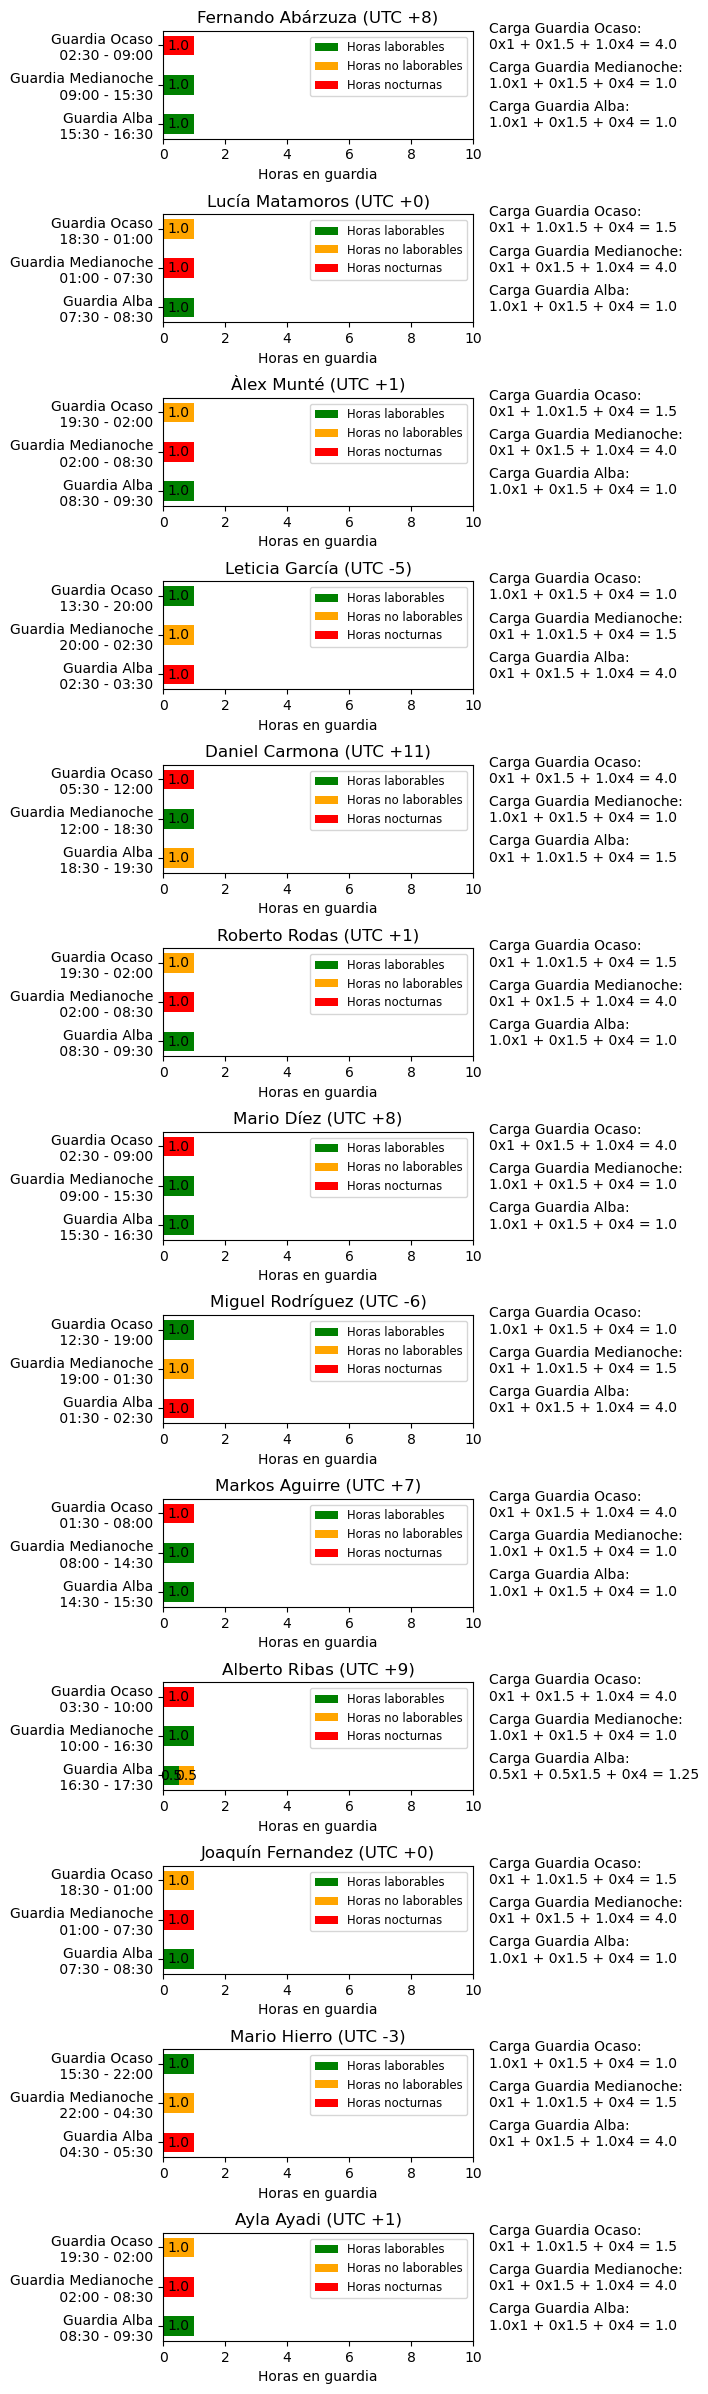

In [4]:
fig, ax =  plt.subplots(len(operadores), figsize=(4, 30))
plt.subplots_adjust(wspace=1,  # Width space between subplots
                    hspace=0.7)  # Height space between subplots
for i in range(len(operadores)):
    ax[i] = operadores[i+1].plot_guardias_en_ax(ax[i])

In [33]:
DIAS = ["L", "M", "X", "J", "V", "S", "D"]
num_dias = 31
num_operadores = len(operadores)+1
calendario = np.random.randint(1, num_operadores, size=(num_dias * 3))

# El dia de la semana (Lunes es 0)
#  0  1  2  3  4  5  6
# [L, M, X, J, V, S ,D]
indice_primer_dia = 4

# El dia del mes en el que empiezan las guardias
dia_calendario = 1

In [34]:
operadores_ocaso = []
operadores_medianoche = []
operadores_alba = []

for id, operador in operadores.items():
    disponibilidad = operador.get_disponibilidad()
    if disponibilidad[0]:
        operadores_ocaso.append(id)
    if disponibilidad[1]:
        operadores_medianoche.append(id)
    if disponibilidad[2]:
        operadores_alba.append(id)

In [35]:
def calcular_fitness_calendario(calendario,
                                operadores,
                                indice_primer_dia,
                                verbose=False):
    """
    Función objetivo de la optimización, calcula la diferencia de carga entre el operario que más
    tiene y el que menos

    Input:
        calendario (np.array): Un numpy array, cada posición corresponde a una guardia y el valor en la posición es el identificador del operador al que se le ha asignado
        operadores (dict): Un diccionario con los operadores
        indice_primer_dia (int): El índice del día en el array dias (Lunes=0, ...)
        verbose (bool): Si es True, se muestran mensajes para debuggear

    Returns:
        fitness (float): El fitness del calendario
        cargas_operadores (np.array): Un array con la carga total de cada operador
    """

    nombres_guardias = ["Guardia Ocaso", "Guardia Medianoche", "Guardia Alba"]
    horarios_ut_guardias = operadores[1].get_horarios_ut_guardias()
    dias = ["L", "M", "X", "J", "V", "S", "D"]
    cargas_operadores = np.zeros(len(operadores))
    guardia = 0
    num_dia = 0
    indice_dia = indice_primer_dia
    for id_operador in calendario:
        if guardia == 0:
            num_dia += 1
            if verbose:
                print(f"Día {num_dia}")

        if guardia == 1:
            indice_dia = (indice_dia+1)%7

        if verbose:
            print(f"*{nombres_guardias[guardia]} (UT: {dias[indice_dia]}-{num_dia} {operadores[1].parsear_franja(horarios_ut_guardias[guardia])}) ")

        cargas_operadores[id_operador-1] += operadores[id_operador].calcular_carga_en_dia(indice_dia,
                                                                                          guardia,
                                                                                          verbose=verbose)
        guardia = (guardia+1)%3

    if verbose:
        print(cargas_operadores)

    diferencia = max(cargas_operadores) - min(cargas_operadores)
    if verbose:
        print(f"La diferencia entre la mayor y menor carga de trabajo de los operarios es {diferencia}")

    if diferencia == 0:
        fitness = 1000
    else:
        fitness = 1/diferencia

    return fitness, cargas_operadores

In [36]:
import random
def crear_propuesta(operadores_ocaso,
                    operadores_medianoche,
                    operadores_alba,
                    num_guardias):
    """
    Crea una propuesta de planificación

    Input:
        operadores_ocaso (list): Una lista con los identificadores de los operadores disponibles en las guardias de ocaso
        operadores_medianoche (list): Una lista con los identificadores de los operadores disponibles en las guardias de medianoche
        operadores_alba (list): Una lista con los identificadores de los operadores disponibles en las guardias de alba
        num_guardias (int): El número de guardias que hay que cubrir

    Return:
        propuesta (list): Una lista con cada posición correspondiente a una guardia con su operador
    """

    propuesta = []
    operadores_por_guardia = [operadores_ocaso, operadores_medianoche, operadores_alba]
    guardia = 0

    for i in range(num_guardias):
        operadores_disponibles = operadores_por_guardia[guardia]
        operador_elegido = random.choice(operadores_disponibles)
        propuesta.append(operador_elegido)
        guardia = (guardia+1)%3

    return propuesta


def inicializar_propuestas(num_propuestas,
                           operadores_ocaso,
                           operadores_medianoche,
                           operadores_alba,
                           num_guardias):
    """
    Crea el número de propuestas deseado

    Input:
        num_propuestas (int): Número de propuestas que hay que hacer
        operadores_ocaso (list): Una lista con los identificadores de los operadores disponibles en las guardias de ocaso
        operadores_medianoche (list): Una lista con los identificadores de los operadores disponibles en las guardias de medianoche
        operadores_alba (list): Una lista con los identificadores de los operadores disponibles en las guardias de alba
        num_guardias (int): El número de guardias que hay que cubrir

    Return:
        propuestas (np.array): Un array con las propuestas creadas
    """
    propuestas = []
    for i in range(num_propuestas):
        nueva_propuesta = crear_propuesta(operadores_ocaso,
                                          operadores_medianoche,
                                          operadores_alba,
                                          num_guardias)
        propuestas.append(nueva_propuesta)

    return np.array(propuestas)


def mutar_offspring(operadores_ocaso,
                    operadores_medianoche,
                    operadores_alba,
                    offspring):
    """
    Función que muta las soluciones encontradas por el algoritmo

    Input:
      operadores_ocaso (list): Una lista con los identificadores de los operadores disponibles en las guardias de ocaso
      operadores_medianoche (list): Una lista con los identificadores de los operadores disponibles en las guardias de medianoche
      operadores_alba (list): Una lista con los identificadores de los operadores disponibles en las guardias de alba
      offspring (np.array): Los cruces de las soluciones obtenidas por el algoritmo

    Returns:
      offspring (np.array): El array con los cruces mutados
    """
    operadores_por_guardia = [operadores_ocaso, operadores_medianoche, operadores_alba]
    guardia = 0

    mutation_rate = 0.1
    num_mutaciones = 3

    for i in range(offspring.shape[0]):
        for m in range(num_mutaciones):
            prob = random.uniform(0, 1)
            if prob < mutation_rate:
                index = random.randint(0, offspring[m].shape[0]-1)
                guardia = index%3
                operadores_disponibles = operadores_por_guardia[guardia]
                operador_elegido = random.choice(operadores_disponibles)
                offspring[i][index] = operador_elegido
    return offspring


def check_validity(offspring,
                   operadores_por_guardia):

    """
    Comprueba que la solución es válida y no se ha asignado una guardia incompatible con el operador
    """
    for o in offspring:
        como_int = o.astype(int)
        guardia = 0
        for i in range(o.shape[0]):
            if como_int[i] not in operadores_por_guardia[guardia]:
                print("MAL")
                return
            guardia = (guardia+1)%3

    print("BIEN")
    return


def corregir_offspring(operadores,
                       operadores_ocaso,
                       operadores_medianoche,
                       operadores_alba,
                       offspring,
                       primer_dia):

    """
    Función que corrige las propuestas en caso de que estén mal
    """
    for i in range(len(offspring)):
        offspring[i] = corregir_calendario(operadores,
                                           operadores_ocaso,
                                           operadores_medianoche,
                                           operadores_alba,
                                           offspring[i],
                                           primer_dia)

    return offspring


def corregir_calendario(operadores,
                        operadores_ocaso,
                        operadores_medianoche,
                        operadores_alba,
                        calendario,
                        primer_dia):

    num_guardias = len(calendario)
    num_dia = primer_dia
    operadores_por_guardia = [operadores_ocaso, operadores_medianoche, operadores_alba]
    guardia = 0

    for i in range(num_guardias):
        cambiar = True
        while cambiar:
            operador_disponible = operadores[calendario[i]].comprobar_disponibilidad(num_dia, guardia)
            cambiar = not operador_disponible
            if cambiar:
                operadores_disponibles = operadores_por_guardia[guardia]
                operador_seleccionado = random.choice(operadores_disponibles)
                calendario[i] = float(operador_seleccionado)
        guardia = (guardia+1)%3
        if guardia == 1:
            num_dia += 1
        if num_dia > 31:
            num_dia = 1
    return calendario


In [37]:
N_PROPUESTAS = 3

propuestas = []
for i in range(0, N_PROPUESTAS):
  # Genetic Algorithm Parameters
  population_size = 150
  num_generations = 200
  num_guardias = num_dias*3

  # Initialization: Create a random population of arrays
  population = inicializar_propuestas(population_size,
                                      operadores_ocaso,
                                      operadores_medianoche,
                                      operadores_alba,
                                      num_guardias)

  population = corregir_offspring(operadores,
                                     operadores_ocaso,
                                     operadores_medianoche,
                                     operadores_alba,
                                     population,
                                     dia_calendario
                                     )

  mejores_combinaciones = np.zeros((10, num_guardias))
  mejores_fitness = np.zeros(10)
  # Main Genetic Algorithm Loop
  for generation in range(num_generations):
      # Calculate fitness for each individual in the population
      fitness_values = np.array([calcular_fitness_calendario(x.astype(int), operadores, indice_primer_dia)[0] for x in population])

      best_individual_index = np.argmax(fitness_values)
      best_fitness = fitness_values[best_individual_index]
      best_individual = population[best_individual_index]


      indice_peor_fitness_global = np.argmin(mejores_fitness)
      peor_fitness_global = mejores_fitness[indice_peor_fitness_global]
      if peor_fitness_global < best_fitness:
          mejores_combinaciones[indice_peor_fitness_global] = best_individual
          mejores_fitness[indice_peor_fitness_global] = best_fitness

      # Selection: Choose parents based on fitness (roulette wheel selection
      if fitness_values.sum() == 0:
          probabilities = np.full(shape=fitness_values.shape, fill_value=3, dtype=np.float)
      else:
          probabilities = fitness_values / fitness_values.sum()
      parent_indices = np.random.choice(population_size, size=population_size, p=probabilities)
      parents = population[parent_indices]

      # Crossover: Perform crossover to create offspring
      crossover_points = np.random.randint(low=1, high=num_guardias, size=(population_size, ))
      offspring = np.zeros((population_size, num_guardias))

      for i in range(0, population_size, 2):
          cross_point = crossover_points[i]
          offspring[i] = np.concatenate((parents[i][:cross_point], parents[i+1][cross_point:])).astype(int)
          offspring[i+1] = np.concatenate((parents[i+1][:cross_point], parents[i][cross_point:])).astype(int)

      # Mutation: Apply mutation to the offspring

      offspring = mutar_offspring(operadores_ocaso,
                                  operadores_medianoche,
                                  operadores_alba,
                                  offspring)

      offspring = corregir_offspring(operadores,
                                     operadores_ocaso,
                                     operadores_medianoche,
                                     operadores_alba,
                                     offspring,
                                     dia_calendario
                                     )
      population = offspring

  best_individual_index = np.argmax(mejores_fitness)
  best_individual = mejores_combinaciones[best_individual_index]
  propuestas.append(best_individual)


In [38]:
for p in propuestas:
  print(p.astype(int))

[12 12  7  2  8  6  4  4 11 12  1  7  6  8  2  6  4  9 13 10 11 12  9 13
  8  7 13  3 10  2  3  7 10 12  5 11  4 10  1  2  5  2  3  1  9  2  9  1
  3  5  7 11  5  3  6 10  2  4  4 13 11  1  3 12 10  5  6 12  9  8  1  5
  8  7 10  4 10  5 11  1  2 12  1 11 13  9 11  8  7  6 13  5  6]
[ 4  4  2 12  7  9  8  5 13 11  1 10  4  8  3  8  1 13 11  8  5  2  1  1
  6  5  6 11  7  1 12  9  9  2  7 13  3 10  7  6 10 10  4 10  3  3 12  3
 13  5 13  2 12  6  8 12 13 13  7  5  6  4  7 12  9 10  2  4  9 11  7 13
  6 10  3 11  7 11  8 10  7  2  5  1 12  9 11  4  5  1  6  8  3]
[ 4 10  1  3  1  5 11  5  2  2  7  5 11  5 11  8 12  6 13 12  3  6  7  9
  3  8  2  6 10  9  3 12  9  3  4 11  4  1  7  2  4  6  6  5  1 13 10 13
  4  8  3 13  9 10  4  8  9 13  9  7 12  5  2 12  7  3  8 10  5 11  4 10
  6  9  2 12 10  2  6  1 13 12  7  1 11  7  9  2  8 13 12  1 11]


In [39]:
for p in propuestas:
  best_fitness = calcular_fitness_calendario(p.astype(int), operadores, indice_primer_dia, True)[0]
  print("Best Calendario:", p.astype(int).flatten())  # Convert the array to a simple listº

Día 1
*Guardia Ocaso (UT: V-1 18:30 - 01:00) 
   La guardia para Mario Hierro empieza el V a las 15:30 con carga de 4.0
*Guardia Medianoche (UT: S-1 01:00 - 07:30) 
   La guardia para Mario Hierro empieza el V a las 22:00 con carga de 4.5
*Guardia Alba (UT: S-1 07:30 - 08:30) 
   La guardia para Mario Díez empieza el S a las 15:30 con carga de 7.0
Día 2
*Guardia Ocaso (UT: S-2 18:30 - 01:00) 
   La guardia para Lucía Matamoros empieza el S a las 18:30 con carga de 7.5
*Guardia Medianoche (UT: D-2 01:00 - 07:30) 
   La guardia para Miguel Rodríguez empieza el S a las 19:00 con carga de 7.5
*Guardia Alba (UT: D-2 07:30 - 08:30) 
   La guardia para Roberto Rodas empieza el D a las 08:30 con carga de 7.0
Día 3
*Guardia Ocaso (UT: D-3 18:30 - 01:00) 
   La guardia para Leticia García empieza el D a las 13:30 con carga de 7.0
*Guardia Medianoche (UT: L-3 01:00 - 07:30) 
   La guardia para Leticia García empieza el D a las 20:00 con carga de 7.5
*Guardia Alba (UT: L-3 07:30 - 08:30) 
   La gu

In [62]:
def plot_calendario(best_individual, indice_primer_dia, num_dia, calendario_nuevos):
  nombres_guardias = ["Ocaso", "Medianoche", "Alba"]
  columnas = ["Hora Tenerife", "Hora UT"]
  for operador in operadores.values():
      columnas.append(operador.get_nombre())
  columnas.append("Hora Tenerife")

  data = []
  dias = ["L", "M", "X", "J", "V", "S", "D"]
  indice_dia = indice_primer_dia
  guardias = operadores[1].get_horarios_ut_guardias()

  for d in range(1, num_dias+1):
      for g in range(3):
          if g == 1:
              indice_dia = (indice_dia+1)%7
              num_dia += 1
          if num_dia > 31:
              num_dia = 1

          cell_info = f"{nombres_guardias[g]}\n{dias[indice_dia]}-{num_dia} {operadores[1].parsear_franja(guardias[g]): >5}"
          row = [cell_info]
          cell_info = f"{dias[indice_dia]}-{num_dia} {operadores[1].parsear_franja(guardias[g]): >5}"
          row.append(cell_info)

          for operador in operadores.values():
              cell_info = operador.parsear_franja_con_dia(indice_dia, num_dia, guardias[g])
              row.append(cell_info)

          cell_info = f"{nombres_guardias[g]}\n{dias[indice_dia]}-{num_dia} {operadores[1].parsear_franja(guardias[g]): >5}"
          row.append(cell_info)

          data.append(row)

  last_row = ["", "Carga total"]
  last_row += list(calcular_fitness_calendario(best_individual.astype(int), operadores, indice_primer_dia)[1])
  last_row += [""]
  data.append(last_row)


  # Create a new figure
  plt.figure(figsize=(50, 75))
  #plt.figure()

  # Create a table and add data to it
  table = plt.table(cellText=data, colLabels=columnas, loc='center', cellLoc="center", bbox=[0, 0, 1, 1])
  table.set_fontsize(16)
  #table.scale(1, 1.5)
  table.auto_set_column_width(col=list(range(len(data[0]))))

  for i in range(0, len(best_individual)):
      cell = table[i+1, best_individual[i]+1]
      cell.set_facecolor('#CCD9C7')

  for i in range(0, len(calendario_nuevos)):
      if calendario_nuevos[i] != 0:
          cell = table[i+1, 14]
          cell.set_facecolor('#CCD9C7')

  for i, in range(3, len(best_individual), 3):
    for j in range(0, len(last_row)):
      cell = table[i, j]
      cell.set_linewidth(2)
        
  # Hide axes
  ax = plt.gca()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
      ax.axhline(y=3
  # Title for the table
  plt.title('Guardias (01 - 31 Marzo)', fontsize=14)

  # Show the table
  plt.show()

In [63]:
calendario_nuevos = np.array([])

TypeError: cannot unpack non-iterable int object

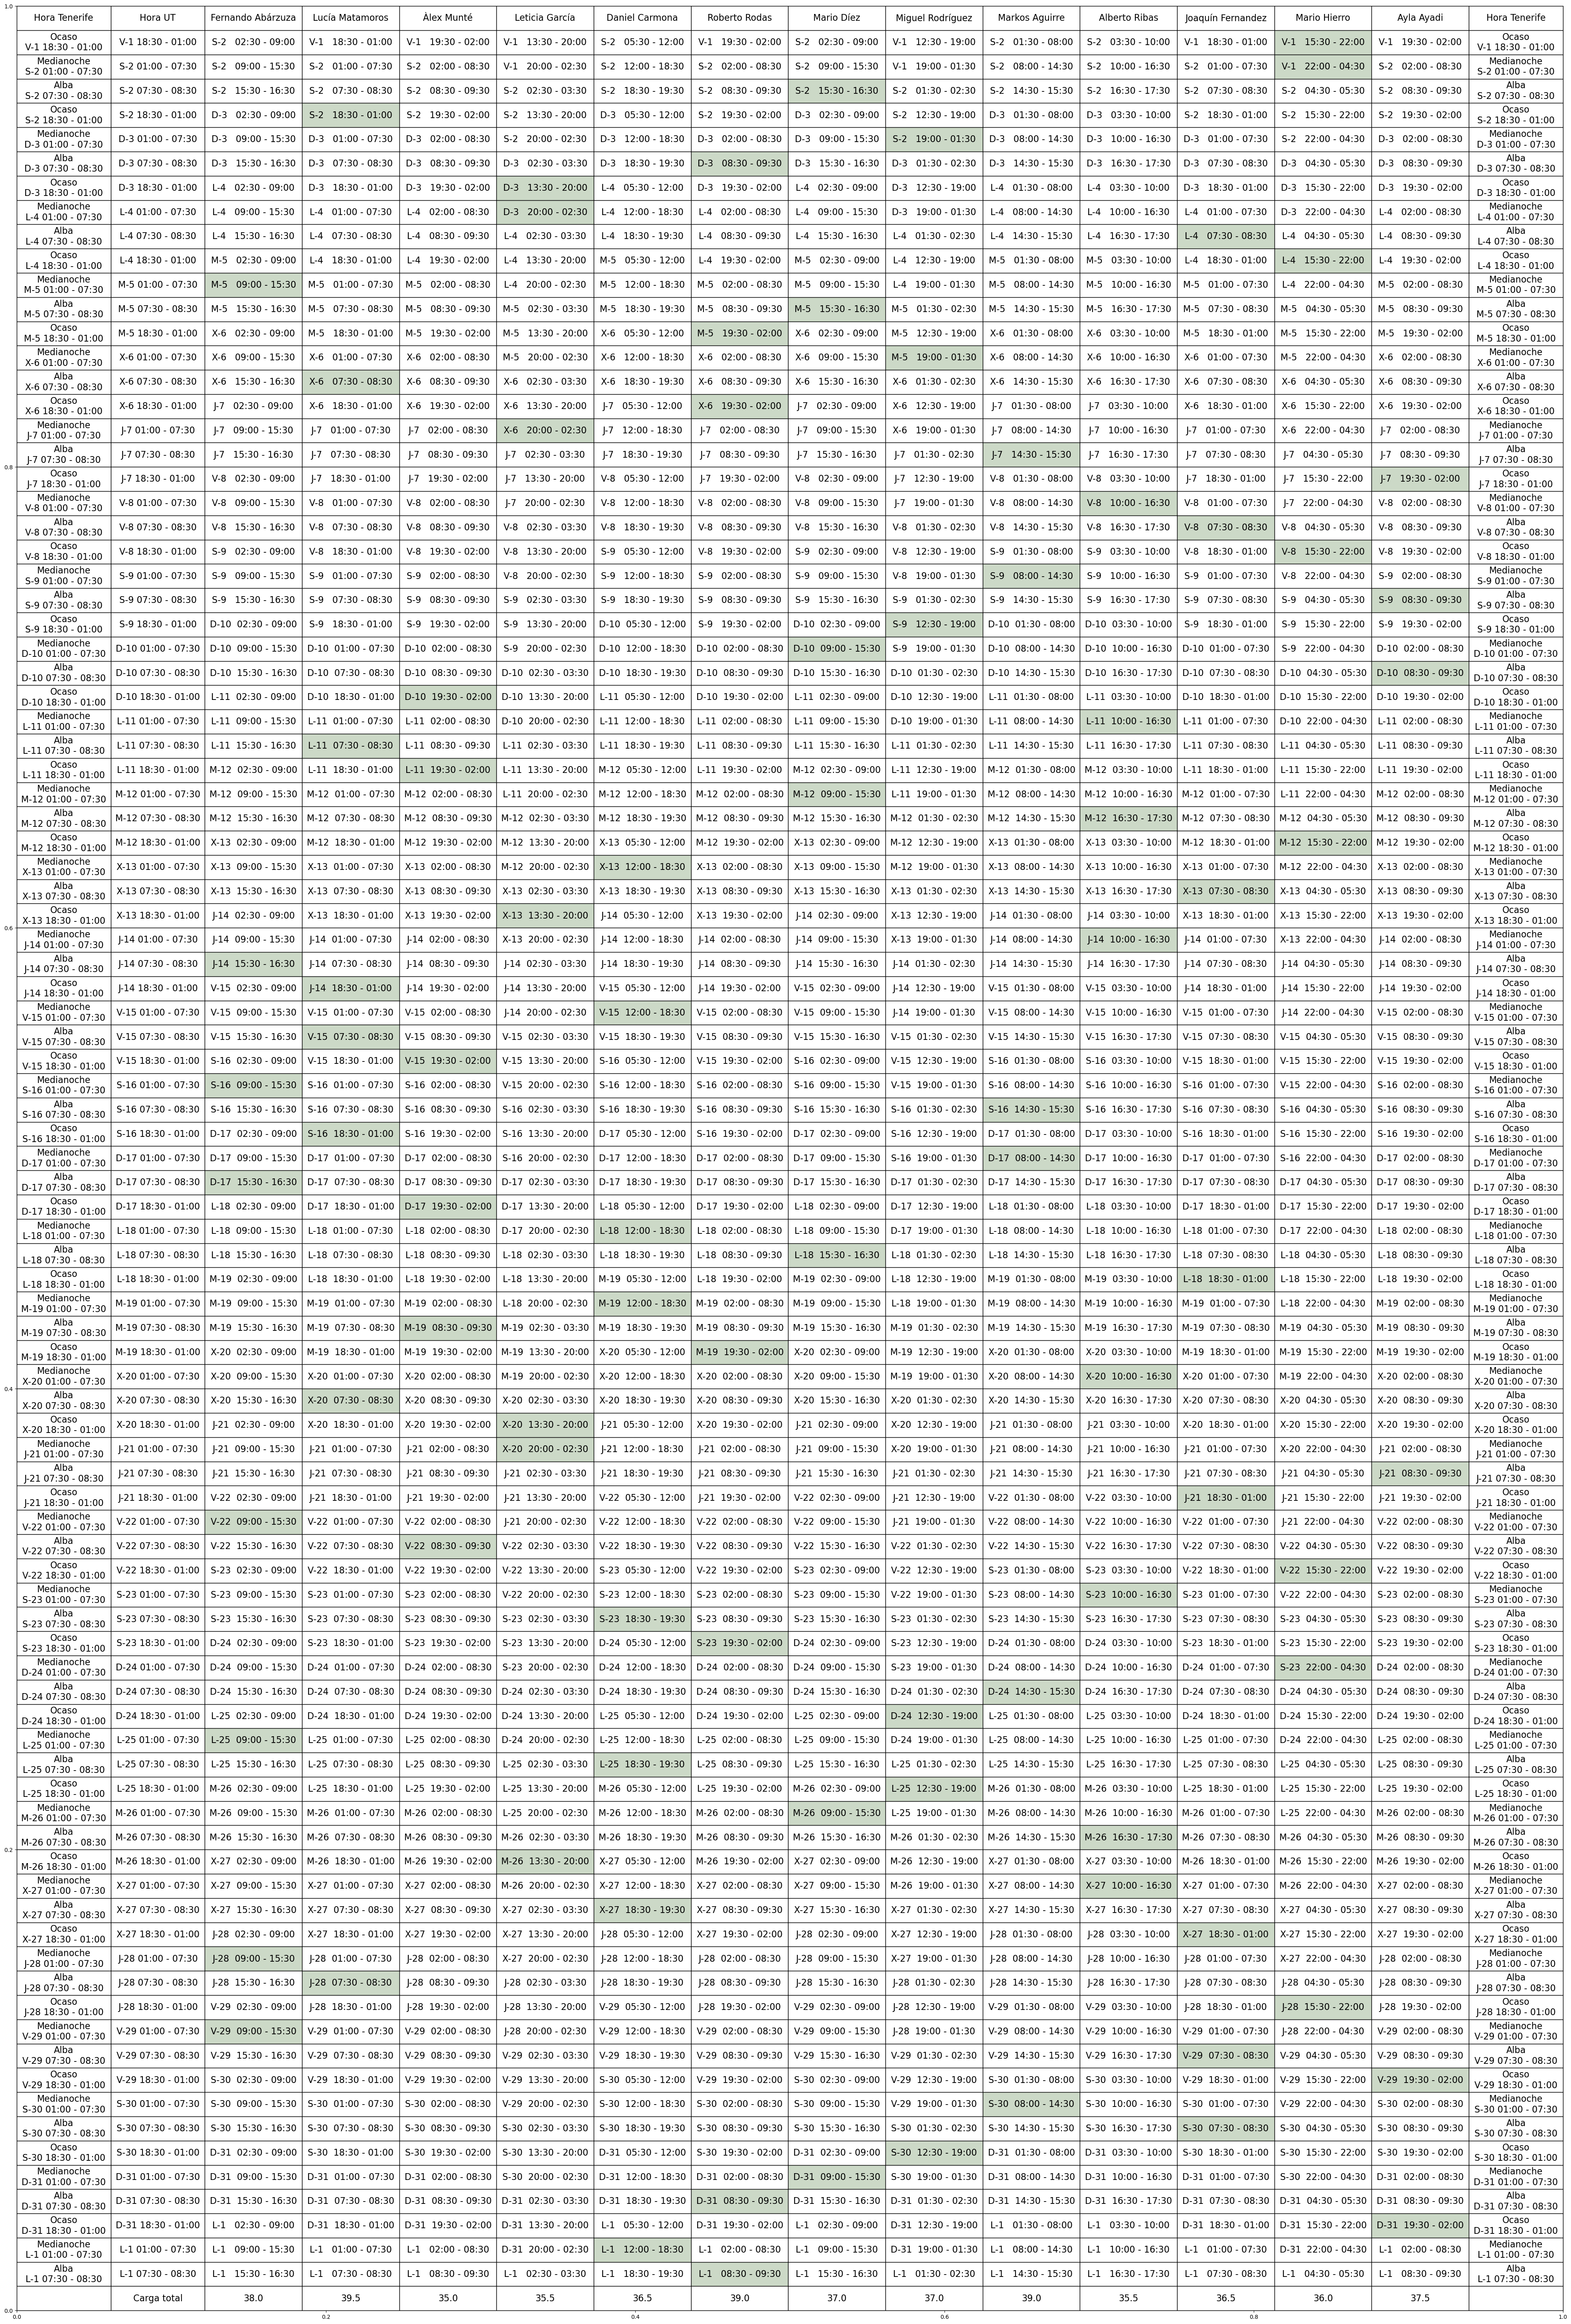

In [64]:
plot_calendario(propuestas[0], indice_primer_dia, dia_calendario, calendario_nuevos)

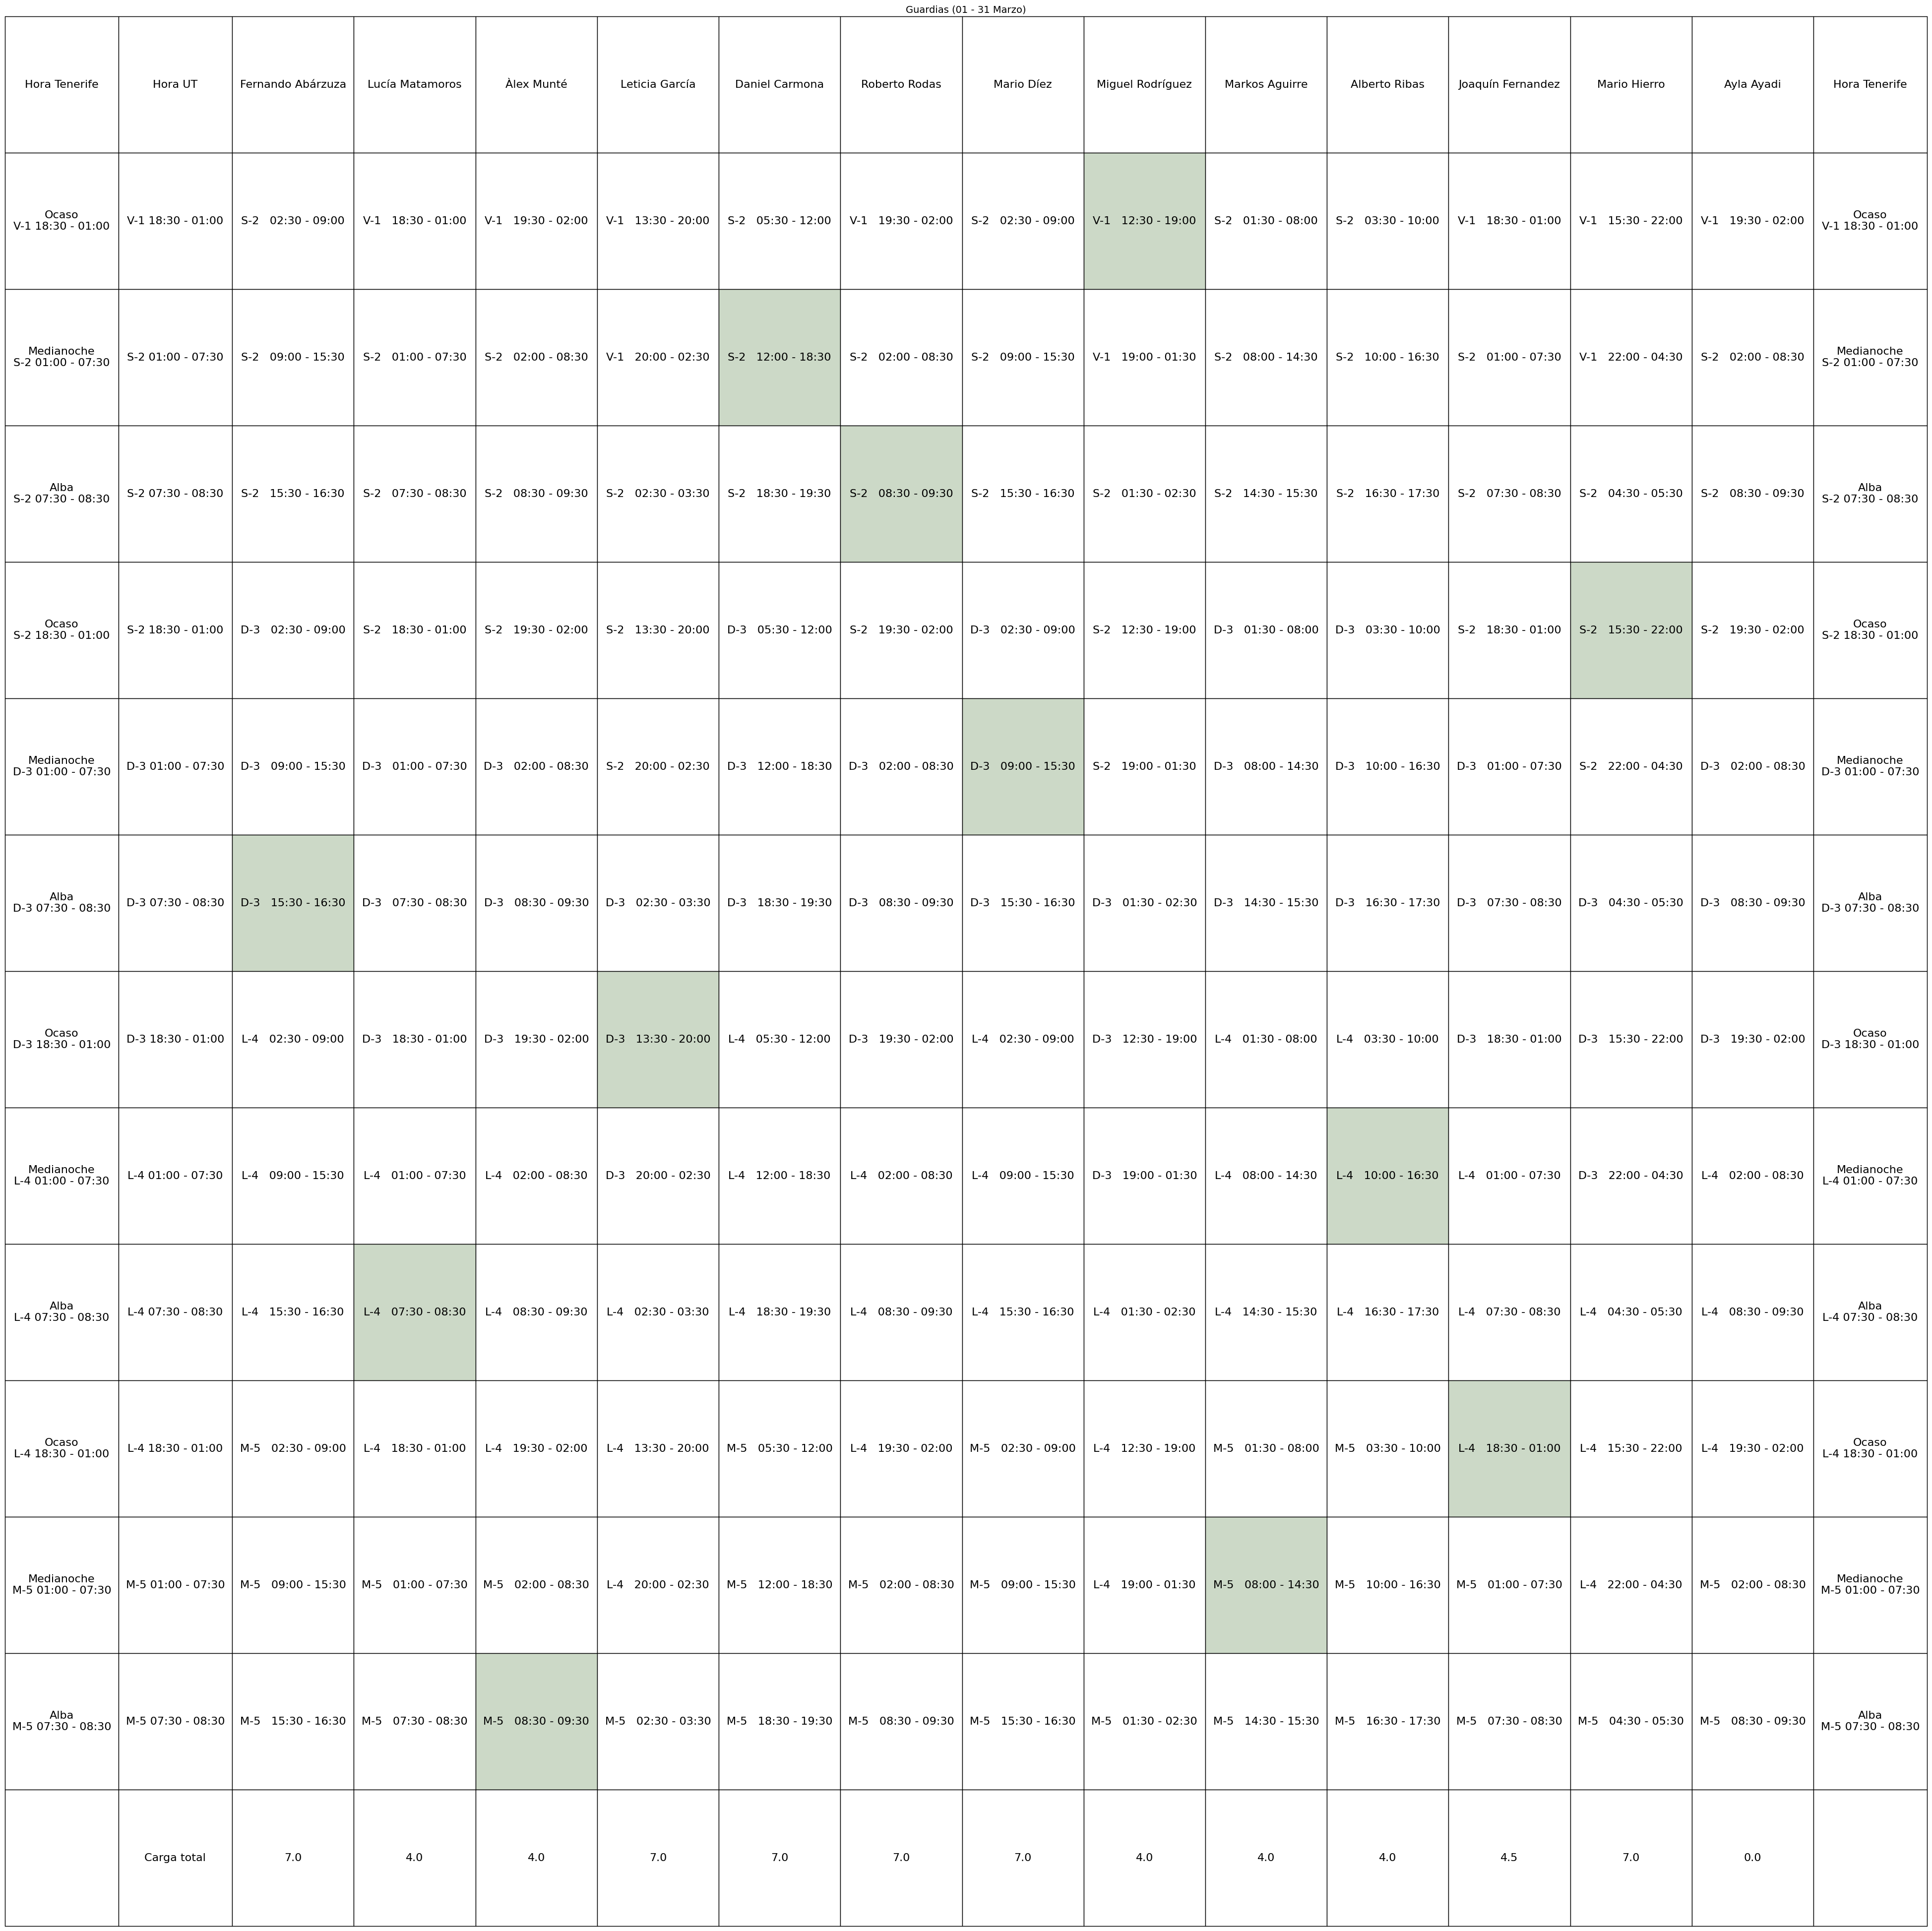

In [32]:

plot_calendario(propuestas[1], indice_primer_dia, dia_calendario, calendario_nuevos)

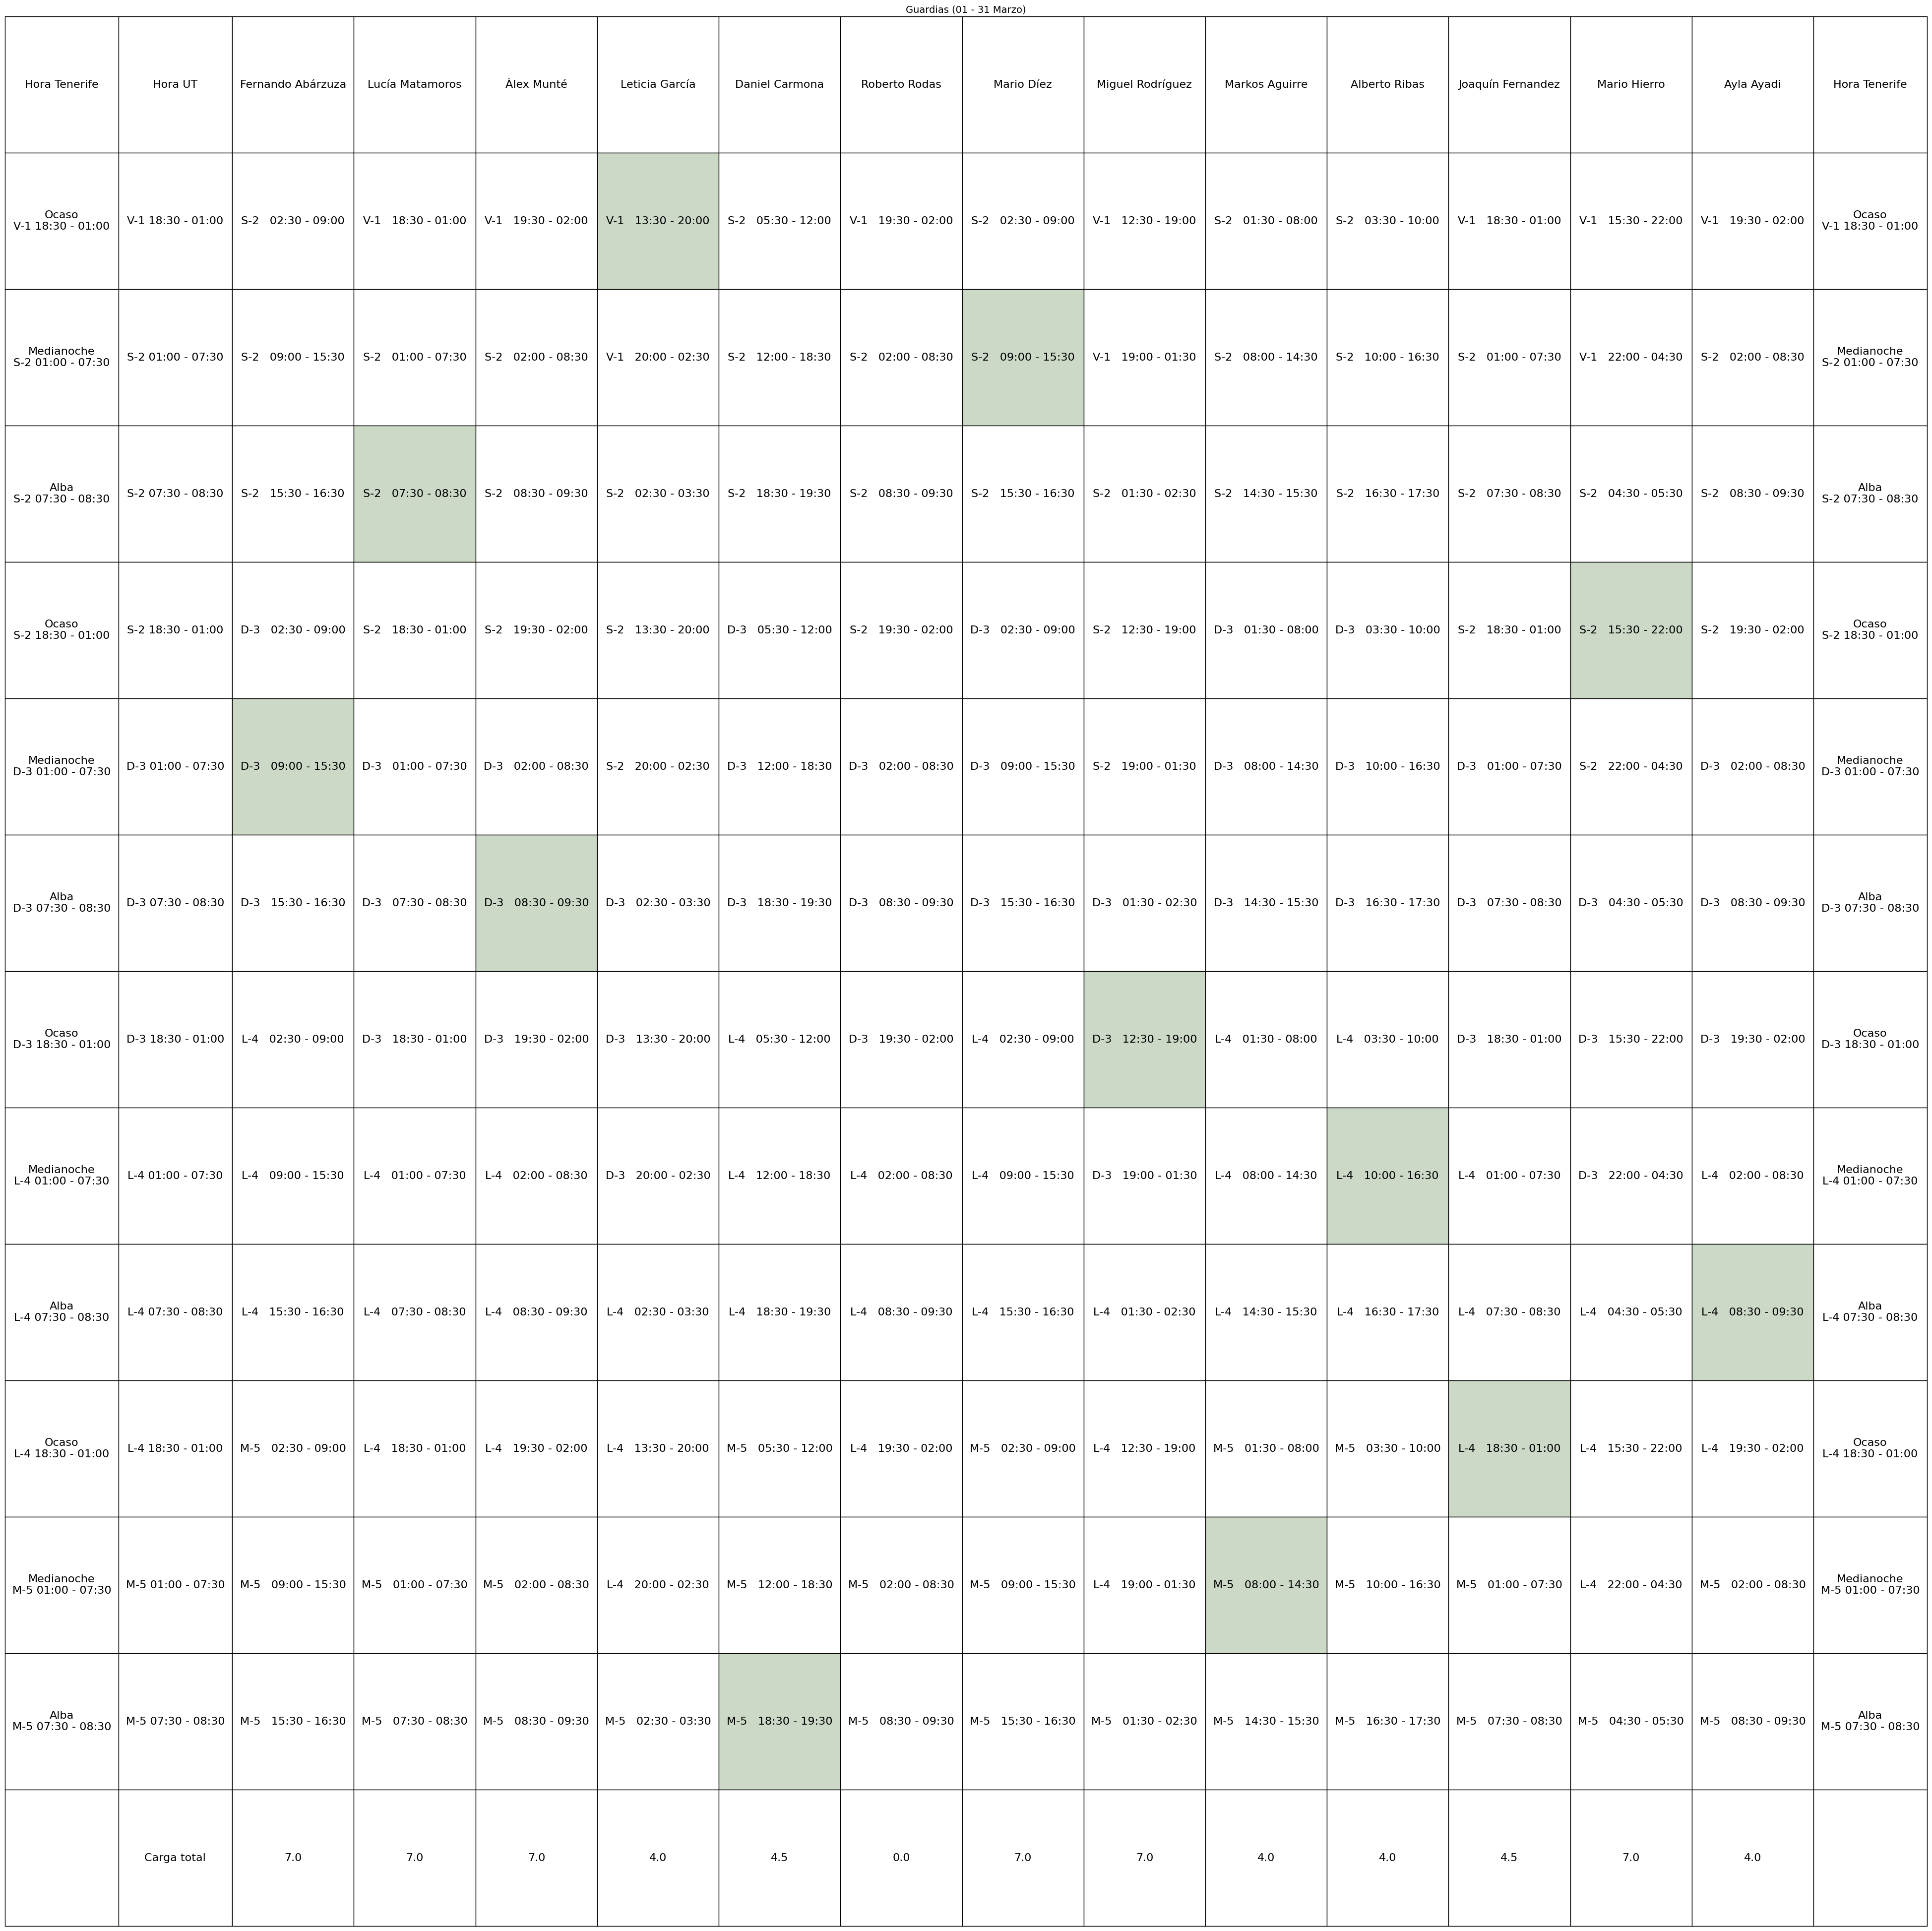

In [33]:
plot_calendario(propuestas[2], indice_primer_dia, dia_calendario, calendario_nuevos)

In [34]:
print(propuestas[0])
print(propuestas[1])
print(propuestas[2])

[11.  1. 10.  6.  4.  2.  3. 12.  7. 13.  5.  9.]
[ 8.  5.  6. 12.  7.  1.  4. 10.  2. 11.  9.  3.]
[ 4.  7.  2. 12.  1.  3.  8. 10. 13. 11.  9.  5.]
